### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


### Dataset and DataLoader

In [2]:
class OHRCDataset(Dataset):
    def __init__(self, root_dir, mask_dir, transform=None):
        self.root_dir = root_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        for class_name in sorted(os.listdir(root_dir)):
            img_dir = os.path.join(root_dir, class_name)
            mask_class_dir = os.path.join(mask_dir, class_name)
            if os.path.isdir(img_dir):
                for img_name in os.listdir(img_dir):
                    if img_name.endswith('.png'):
                        self.image_paths.append(os.path.join(img_dir, img_name))
                        self.mask_paths.append(os.path.join(mask_class_dir, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        return img, mask


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

In [3]:
def load_data(train_dir, val_dir, test_dir, batch_size):
    trainset = OHRCDataset(train_dir+"/images", train_dir+"/masks", transform)
    valset = OHRCDataset(val_dir+"/images", val_dir+"/masks", transform)
    testset = OHRCDataset(test_dir+"/images", test_dir+"/masks", transform)

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

### Evaluation Metrics

In [4]:
def threshold(pred, thresh=0.5):
    """Convert probability map to binary mask."""
    return (torch.sigmoid(pred) > thresh).float()

def dice_score(pred, target, smooth=1e-6):
    pred = threshold(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2 * intersection + smooth) / (union + smooth)

def iou_score(pred, target, smooth=1e-6):
    pred = threshold(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def pixel_accuracy(pred, target):
    pred = threshold(pred)
    correct = (pred == target).float().sum()
    total = torch.numel(pred)
    return correct / total

# --- Combined BCE + Dice Loss ---
bce_loss = nn.BCEWithLogitsLoss()

def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    inter = (pred * target).sum()
    union = pred.sum() + target.sum()
    return 1 - ((2 * inter + smooth) / (union + smooth))

def combined_loss(pred, target):
    return 0.5 * bce_loss(pred, target) + 0.5 * dice_loss(pred, target)


## U-Net Model

In [5]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(n_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = conv_block(512, 1024)

        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec1 = conv_block(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec2 = conv_block(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = conv_block(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec4 = conv_block(128, 64)
        self.out_conv = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.pool(x1)
        x3 = self.enc2(x2)
        x4 = self.pool(x3)
        x5 = self.enc3(x4)
        x6 = self.pool(x5)
        x7 = self.enc4(x6)
        x8 = self.pool(x7)
        x9 = self.bottleneck(x8)

        x = self.up1(x9)
        x = self.dec1(torch.cat([x, x7], dim=1))
        x = self.up2(x)
        x = self.dec2(torch.cat([x, x5], dim=1))
        x = self.up3(x)
        x = self.dec3(torch.cat([x, x3], dim=1))
        x = self.up4(x)
        x = self.dec4(torch.cat([x, x1], dim=1))
        return self.out_conv(x)


## Training with metrics per epoch

In [6]:
def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-4, patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Optimizer, scheduler, and scaler
    opt = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)
    scaler = GradScaler(device="cuda")

    best_val_loss = np.inf
    patience_counter = 0

    print("Training Started...\n")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        val_loss = 0.0
        train_stats = {"dice": 0, "iou": 0, "acc": 0}

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        # -----------------------------
        # Training Phase
        # -----------------------------
        for img, mask in loop:
            img, mask = img.to(device), mask.to(device)
            opt.zero_grad()

            # Mixed Precision forward pass
            with autocast(device_type="cuda"):
                pred = model(img)
                loss = combined_loss(pred, mask)  # BCE + Dice loss

            # Backpropagation with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            train_loss += loss.item()

            # Accumulate metrics
            train_stats["dice"] += dice_score(pred, mask).item()
            train_stats["iou"] += iou_score(pred, mask).item()
            train_stats["acc"] += pixel_accuracy(pred, mask).item()

        # Normalize train stats
        for k in train_stats:
            train_stats[k] /= len(train_loader)
        train_loss /= len(train_loader)

        # -----------------------------
        # Validation Phase
        # -----------------------------
        model.eval()
        with torch.no_grad():
            for img, mask in val_loader:
                img, mask = img.to(device), mask.to(device)
                with autocast(device_type="cuda"):
                    pred = model(img)
                    val_loss += combined_loss(pred, mask).item()

        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        # Learning rate log (optional)
        if scheduler.num_bad_epochs == 0:
            print(f"LR reduced to {scheduler.optimizer.param_groups[0]['lr']:.2e}")

        # -----------------------------
        # Epoch Summary
        # -----------------------------
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Dice: {train_stats['dice']:.3f}, IoU: {train_stats['iou']:.3f}, Acc: {train_stats['acc']:.3f}")

        # -----------------------------
        # Early Stopping
        # -----------------------------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("\nEarly stopping triggered!")
                break

    print(f"\nTraining Complete. Best Validation Loss: {best_val_loss:.4f}")


## Test Evaluation Helper Function

In [12]:
def test_evaluation(model, loader):
    model.eval()
    model.to(device)
    stats = {"Dice":0, "IoU":0, "Accuracy":0}

    with torch.no_grad():
        for img, mask in loader:
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            stats["Dice"] += dice_score(pred, mask)
            stats["IoU"] += iou_score(pred, mask)
            stats["Accuracy"] += pixel_accuracy(pred, mask)

    for k in stats: stats[k] /= len(loader)
    df = pd.DataFrame([stats])
    print("\nTEST METRICS SUMMARY")
    display(df.style.set_caption("Segmentation Performance Metrics").format("{:.4f}"))
    return df

## Visualize predictions and ground truth

In [8]:
def show_all_visualizations(model, loader, num_samples=3):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)

    with torch.no_grad():
        preds = torch.sigmoid(model(imgs))
        preds = (preds > 0.5).float()

    for i in range(min(num_samples, len(imgs))):
        img = imgs[i].permute(1, 2, 0).cpu().numpy()
        mask_gt = masks[i][0].cpu().numpy()
        mask_pred = preds[i][0].cpu().numpy()

        if img.max() > 1:
            img = img / 255.0

        # --- Overlay (Red=Prediction, Green=GT) ---
        overlay = img.copy()
        overlay[..., 0] += mask_pred * 0.8
        overlay[..., 1] += mask_gt * 0.8
        overlay = np.clip(overlay, 0, 1)

        # --- Contour visualization ---
        image_cv = (img * 255).astype(np.uint8)
        pred_cv = (mask_pred * 255).astype(np.uint8)
        vis = image_cv.copy()

        contours, _ = cv2.findContours(pred_cv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for c in contours:
            area = cv2.contourArea(c)
            per = cv2.arcLength(c, True)
            if per == 0: continue
            circ = 4 * np.pi * area / (per ** 2)
            if area > 20:
                cv2.drawContours(vis, [c], -1, (0, 0, 255), 1)
                M = cv2.moments(c)
                if M["m00"] != 0:
                    cx, cy = int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"])
                    cv2.putText(vis, f"{circ:.2f}", (cx, cy),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1)

        gt_cv = (mask_gt * 255).astype(np.uint8)
        contours_gt, _ = cv2.findContours(gt_cv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(vis, contours_gt, -1, (0,255,0), 1)  # Green = GT

        vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)

        # --- Combined 2x2 Layout ---
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))
        axes[0, 0].imshow(img)
        axes[0, 0].set_title("Input Image"); axes[0, 0].axis("off")

        axes[0, 1].imshow(mask_gt, cmap="gray")
        axes[0, 1].set_title("Ground Truth"); axes[0, 1].axis("off")

        axes[1, 0].imshow(overlay)
        axes[1, 0].set_title("Overlay (Red=Pred, Green=GT)"); axes[1, 0].axis("off")

        axes[1, 1].imshow(vis_rgb)
        axes[1, 1].set_title("Contours (Red=Pred, Green=GT, Label=Circularity)")
        axes[1, 1].axis("off")

        plt.tight_layout()
        plt.show()

## Training UNet Model

In [9]:
train_loader, val_loader, test_loader = load_data(
    "/teamspace/uploads/OHRC-ISRO/dataset/train",
    "/teamspace/uploads/OHRC-ISRO/dataset/val",
    "/teamspace/uploads/OHRC-ISRO/dataset/test",
    batch_size=4
)

model = UNet()
train_model(model, train_loader, val_loader, num_epochs=100)

Training Started...



Epoch 1/100: 100%|██████████| 80/80 [02:26<00:00,  1.83s/it]


LR reduced to 1.00e-04

Epoch 1/100
Train Loss: 0.7490 | Val Loss: 0.7060
Dice: 0.222, IoU: 0.133, Acc: 0.783


Epoch 2/100: 100%|██████████| 80/80 [02:24<00:00,  1.81s/it]


LR reduced to 1.00e-04

Epoch 2/100
Train Loss: 0.6635 | Val Loss: 0.6458
Dice: 0.310, IoU: 0.188, Acc: 0.916


Epoch 3/100: 100%|██████████| 80/80 [02:05<00:00,  1.57s/it]


LR reduced to 1.00e-04

Epoch 3/100
Train Loss: 0.6349 | Val Loss: 0.6241
Dice: 0.341, IoU: 0.209, Acc: 0.921


Epoch 4/100: 100%|██████████| 80/80 [01:54<00:00,  1.43s/it]


LR reduced to 1.00e-04

Epoch 4/100
Train Loss: 0.6178 | Val Loss: 0.5988
Dice: 0.321, IoU: 0.197, Acc: 0.919


Epoch 5/100: 100%|██████████| 80/80 [01:50<00:00,  1.38s/it]



Epoch 5/100
Train Loss: 0.5981 | Val Loss: 0.6293
Dice: 0.340, IoU: 0.208, Acc: 0.923


Epoch 6/100: 100%|██████████| 80/80 [01:47<00:00,  1.34s/it]


LR reduced to 1.00e-04

Epoch 6/100
Train Loss: 0.5824 | Val Loss: 0.5739
Dice: 0.318, IoU: 0.194, Acc: 0.919


Epoch 7/100: 100%|██████████| 80/80 [01:42<00:00,  1.28s/it]


LR reduced to 1.00e-04

Epoch 7/100
Train Loss: 0.5666 | Val Loss: 0.5567
Dice: 0.349, IoU: 0.215, Acc: 0.921


Epoch 8/100: 100%|██████████| 80/80 [01:41<00:00,  1.27s/it]


LR reduced to 1.00e-04

Epoch 8/100
Train Loss: 0.5504 | Val Loss: 0.5461
Dice: 0.363, IoU: 0.225, Acc: 0.925


Epoch 9/100: 100%|██████████| 80/80 [01:39<00:00,  1.24s/it]


LR reduced to 1.00e-04

Epoch 9/100
Train Loss: 0.5348 | Val Loss: 0.5442
Dice: 0.388, IoU: 0.242, Acc: 0.927


Epoch 10/100: 100%|██████████| 80/80 [01:40<00:00,  1.25s/it]


LR reduced to 1.00e-04

Epoch 10/100
Train Loss: 0.5237 | Val Loss: 0.5106
Dice: 0.372, IoU: 0.232, Acc: 0.926


Epoch 11/100: 100%|██████████| 80/80 [01:38<00:00,  1.24s/it]



Epoch 11/100
Train Loss: 0.5210 | Val Loss: 0.5310
Dice: 0.323, IoU: 0.197, Acc: 0.916


Epoch 12/100: 100%|██████████| 80/80 [01:37<00:00,  1.22s/it]


LR reduced to 1.00e-04

Epoch 12/100
Train Loss: 0.5031 | Val Loss: 0.5020
Dice: 0.370, IoU: 0.229, Acc: 0.925


Epoch 13/100: 100%|██████████| 80/80 [01:37<00:00,  1.22s/it]


LR reduced to 1.00e-04

Epoch 13/100
Train Loss: 0.4974 | Val Loss: 0.4889
Dice: 0.344, IoU: 0.212, Acc: 0.921


Epoch 14/100: 100%|██████████| 80/80 [01:38<00:00,  1.23s/it]


LR reduced to 1.00e-04

Epoch 14/100
Train Loss: 0.4843 | Val Loss: 0.4744
Dice: 0.378, IoU: 0.235, Acc: 0.927


Epoch 15/100: 100%|██████████| 80/80 [01:37<00:00,  1.22s/it]


LR reduced to 1.00e-04

Epoch 15/100
Train Loss: 0.4723 | Val Loss: 0.4615
Dice: 0.392, IoU: 0.246, Acc: 0.927


Epoch 16/100: 100%|██████████| 80/80 [01:37<00:00,  1.22s/it]


LR reduced to 1.00e-04

Epoch 16/100
Train Loss: 0.4631 | Val Loss: 0.4587
Dice: 0.393, IoU: 0.246, Acc: 0.927


Epoch 17/100: 100%|██████████| 80/80 [01:37<00:00,  1.22s/it]



Epoch 17/100
Train Loss: 0.4539 | Val Loss: 0.4594
Dice: 0.392, IoU: 0.245, Acc: 0.927


Epoch 18/100: 100%|██████████| 80/80 [01:38<00:00,  1.23s/it]


LR reduced to 1.00e-04

Epoch 18/100
Train Loss: 0.4474 | Val Loss: 0.4422
Dice: 0.398, IoU: 0.250, Acc: 0.927


Epoch 19/100: 100%|██████████| 80/80 [01:37<00:00,  1.22s/it]


LR reduced to 1.00e-04

Epoch 19/100
Train Loss: 0.4339 | Val Loss: 0.4290
Dice: 0.403, IoU: 0.254, Acc: 0.928


Epoch 20/100: 100%|██████████| 80/80 [01:36<00:00,  1.21s/it]


LR reduced to 1.00e-04

Epoch 20/100
Train Loss: 0.4298 | Val Loss: 0.4279
Dice: 0.394, IoU: 0.247, Acc: 0.926


Epoch 21/100: 100%|██████████| 80/80 [01:36<00:00,  1.21s/it]


LR reduced to 1.00e-04

Epoch 21/100
Train Loss: 0.4224 | Val Loss: 0.4247
Dice: 0.406, IoU: 0.256, Acc: 0.928


Epoch 22/100: 100%|██████████| 80/80 [01:37<00:00,  1.21s/it]


LR reduced to 1.00e-04

Epoch 22/100
Train Loss: 0.4145 | Val Loss: 0.4167
Dice: 0.403, IoU: 0.254, Acc: 0.928


Epoch 23/100: 100%|██████████| 80/80 [01:35<00:00,  1.19s/it]


LR reduced to 1.00e-04

Epoch 23/100
Train Loss: 0.4118 | Val Loss: 0.4082
Dice: 0.404, IoU: 0.254, Acc: 0.928


Epoch 24/100: 100%|██████████| 80/80 [01:36<00:00,  1.20s/it]


LR reduced to 1.00e-04

Epoch 24/100
Train Loss: 0.3999 | Val Loss: 0.4043
Dice: 0.410, IoU: 0.259, Acc: 0.928


Epoch 25/100: 100%|██████████| 80/80 [01:36<00:00,  1.21s/it]


LR reduced to 1.00e-04

Epoch 25/100
Train Loss: 0.3946 | Val Loss: 0.3921
Dice: 0.410, IoU: 0.259, Acc: 0.928


Epoch 26/100: 100%|██████████| 80/80 [01:36<00:00,  1.20s/it]



Epoch 26/100
Train Loss: 0.3943 | Val Loss: 0.3985
Dice: 0.408, IoU: 0.257, Acc: 0.928


Epoch 27/100: 100%|██████████| 80/80 [01:34<00:00,  1.18s/it]


LR reduced to 1.00e-04

Epoch 27/100
Train Loss: 0.3846 | Val Loss: 0.3845
Dice: 0.412, IoU: 0.261, Acc: 0.928


Epoch 28/100: 100%|██████████| 80/80 [01:36<00:00,  1.20s/it]



Epoch 28/100
Train Loss: 0.3998 | Val Loss: 0.3975
Dice: 0.376, IoU: 0.235, Acc: 0.926


Epoch 29/100: 100%|██████████| 80/80 [01:35<00:00,  1.19s/it]



Epoch 29/100
Train Loss: 0.3894 | Val Loss: 0.3932
Dice: 0.389, IoU: 0.243, Acc: 0.928


Epoch 30/100: 100%|██████████| 80/80 [01:34<00:00,  1.18s/it]



Epoch 30/100
Train Loss: 0.3851 | Val Loss: 0.3869
Dice: 0.391, IoU: 0.245, Acc: 0.927


Epoch 31/100: 100%|██████████| 80/80 [01:35<00:00,  1.20s/it]


LR reduced to 5.00e-05

Epoch 31/100
Train Loss: 0.3871 | Val Loss: 0.3998
Dice: 0.381, IoU: 0.238, Acc: 0.927


Epoch 32/100: 100%|██████████| 80/80 [01:34<00:00,  1.18s/it]


LR reduced to 5.00e-05

Epoch 32/100
Train Loss: 0.3791 | Val Loss: 0.3770
Dice: 0.396, IoU: 0.249, Acc: 0.928


Epoch 33/100: 100%|██████████| 80/80 [01:37<00:00,  1.22s/it]



Epoch 33/100
Train Loss: 0.3737 | Val Loss: 0.3801
Dice: 0.411, IoU: 0.260, Acc: 0.928


Epoch 34/100: 100%|██████████| 80/80 [01:37<00:00,  1.21s/it]


LR reduced to 5.00e-05

Epoch 34/100
Train Loss: 0.3692 | Val Loss: 0.3763
Dice: 0.418, IoU: 0.265, Acc: 0.929


Epoch 35/100: 100%|██████████| 80/80 [01:41<00:00,  1.26s/it]


LR reduced to 5.00e-05

Epoch 35/100
Train Loss: 0.3673 | Val Loss: 0.3708
Dice: 0.417, IoU: 0.264, Acc: 0.929


Epoch 36/100: 100%|██████████| 80/80 [01:40<00:00,  1.26s/it]



Epoch 36/100
Train Loss: 0.3661 | Val Loss: 0.3716
Dice: 0.419, IoU: 0.265, Acc: 0.929


Epoch 37/100: 100%|██████████| 80/80 [01:41<00:00,  1.27s/it]



Epoch 37/100
Train Loss: 0.3659 | Val Loss: 0.3727
Dice: 0.413, IoU: 0.261, Acc: 0.928


Epoch 38/100: 100%|██████████| 80/80 [01:39<00:00,  1.25s/it]


LR reduced to 5.00e-05

Epoch 38/100
Train Loss: 0.3611 | Val Loss: 0.3697
Dice: 0.423, IoU: 0.269, Acc: 0.929


Epoch 39/100: 100%|██████████| 80/80 [01:39<00:00,  1.25s/it]


LR reduced to 5.00e-05

Epoch 39/100
Train Loss: 0.3649 | Val Loss: 0.3651
Dice: 0.414, IoU: 0.262, Acc: 0.928


Epoch 40/100: 100%|██████████| 80/80 [01:38<00:00,  1.23s/it]



Epoch 40/100
Train Loss: 0.3588 | Val Loss: 0.3689
Dice: 0.417, IoU: 0.264, Acc: 0.928


Epoch 41/100: 100%|██████████| 80/80 [01:38<00:00,  1.23s/it]



Epoch 41/100
Train Loss: 0.3570 | Val Loss: 0.3661
Dice: 0.423, IoU: 0.269, Acc: 0.929


Epoch 42/100: 100%|██████████| 80/80 [01:39<00:00,  1.24s/it]


LR reduced to 5.00e-05

Epoch 42/100
Train Loss: 0.3576 | Val Loss: 0.3648
Dice: 0.421, IoU: 0.267, Acc: 0.928


Epoch 43/100: 100%|██████████| 80/80 [01:38<00:00,  1.23s/it]


LR reduced to 5.00e-05

Epoch 43/100
Train Loss: 0.3568 | Val Loss: 0.3633
Dice: 0.419, IoU: 0.266, Acc: 0.928


Epoch 44/100: 100%|██████████| 80/80 [01:36<00:00,  1.21s/it]


LR reduced to 5.00e-05

Epoch 44/100
Train Loss: 0.3601 | Val Loss: 0.3615
Dice: 0.414, IoU: 0.262, Acc: 0.928


Epoch 45/100: 100%|██████████| 80/80 [01:37<00:00,  1.22s/it]


LR reduced to 5.00e-05

Epoch 45/100
Train Loss: 0.3569 | Val Loss: 0.3600
Dice: 0.417, IoU: 0.264, Acc: 0.928


Epoch 46/100: 100%|██████████| 80/80 [01:36<00:00,  1.21s/it]



Epoch 46/100
Train Loss: 0.3538 | Val Loss: 0.3666
Dice: 0.420, IoU: 0.266, Acc: 0.928


Epoch 47/100: 100%|██████████| 80/80 [01:36<00:00,  1.21s/it]



Epoch 47/100
Train Loss: 0.3549 | Val Loss: 0.3607
Dice: 0.419, IoU: 0.266, Acc: 0.929


Epoch 48/100: 100%|██████████| 80/80 [01:35<00:00,  1.20s/it]


LR reduced to 5.00e-05

Epoch 48/100
Train Loss: 0.3550 | Val Loss: 0.3583
Dice: 0.416, IoU: 0.263, Acc: 0.929


Epoch 49/100: 100%|██████████| 80/80 [01:36<00:00,  1.21s/it]



Epoch 49/100
Train Loss: 0.3527 | Val Loss: 0.3637
Dice: 0.420, IoU: 0.267, Acc: 0.928


Epoch 50/100: 100%|██████████| 80/80 [01:36<00:00,  1.21s/it]



Epoch 50/100
Train Loss: 0.3526 | Val Loss: 0.3637
Dice: 0.420, IoU: 0.267, Acc: 0.928


Epoch 51/100: 100%|██████████| 80/80 [01:37<00:00,  1.22s/it]



Epoch 51/100
Train Loss: 0.3498 | Val Loss: 0.3585
Dice: 0.420, IoU: 0.266, Acc: 0.928


Epoch 52/100: 100%|██████████| 80/80 [01:38<00:00,  1.23s/it]


LR reduced to 2.50e-05

Epoch 52/100
Train Loss: 0.3509 | Val Loss: 0.3613
Dice: 0.421, IoU: 0.267, Acc: 0.929


Epoch 53/100: 100%|██████████| 80/80 [01:36<00:00,  1.20s/it]



Epoch 53/100
Train Loss: 0.3509 | Val Loss: 0.3597
Dice: 0.418, IoU: 0.265, Acc: 0.928


Epoch 54/100: 100%|██████████| 80/80 [01:35<00:00,  1.19s/it]


LR reduced to 2.50e-05

Epoch 54/100
Train Loss: 0.3503 | Val Loss: 0.3496
Dice: 0.418, IoU: 0.265, Acc: 0.929


Epoch 55/100: 100%|██████████| 80/80 [01:35<00:00,  1.19s/it]


LR reduced to 2.50e-05

Epoch 55/100
Train Loss: 0.3464 | Val Loss: 0.3477
Dice: 0.424, IoU: 0.270, Acc: 0.929


Epoch 56/100: 100%|██████████| 80/80 [01:34<00:00,  1.19s/it]



Epoch 56/100
Train Loss: 0.3450 | Val Loss: 0.3507
Dice: 0.427, IoU: 0.271, Acc: 0.929


Epoch 57/100: 100%|██████████| 80/80 [01:35<00:00,  1.19s/it]



Epoch 57/100
Train Loss: 0.3461 | Val Loss: 0.3559
Dice: 0.424, IoU: 0.270, Acc: 0.929


Epoch 58/100: 100%|██████████| 80/80 [01:35<00:00,  1.19s/it]


LR reduced to 2.50e-05

Epoch 58/100
Train Loss: 0.3441 | Val Loss: 0.3445
Dice: 0.428, IoU: 0.273, Acc: 0.929


Epoch 59/100: 100%|██████████| 80/80 [01:35<00:00,  1.19s/it]



Epoch 59/100
Train Loss: 0.3472 | Val Loss: 0.3553
Dice: 0.424, IoU: 0.269, Acc: 0.928


Epoch 60/100: 100%|██████████| 80/80 [01:33<00:00,  1.17s/it]



Epoch 60/100
Train Loss: 0.3480 | Val Loss: 0.3506
Dice: 0.421, IoU: 0.267, Acc: 0.928


Epoch 61/100: 100%|██████████| 80/80 [01:34<00:00,  1.18s/it]



Epoch 61/100
Train Loss: 0.3447 | Val Loss: 0.3450
Dice: 0.424, IoU: 0.269, Acc: 0.929


Epoch 62/100: 100%|██████████| 80/80 [01:34<00:00,  1.18s/it]


LR reduced to 1.25e-05

Epoch 62/100
Train Loss: 0.3435 | Val Loss: 0.3462
Dice: 0.426, IoU: 0.271, Acc: 0.929


Epoch 63/100: 100%|██████████| 80/80 [01:34<00:00,  1.18s/it]


LR reduced to 1.25e-05

Epoch 63/100
Train Loss: 0.3458 | Val Loss: 0.3432
Dice: 0.423, IoU: 0.269, Acc: 0.929


Epoch 64/100: 100%|██████████| 80/80 [01:34<00:00,  1.18s/it]


LR reduced to 1.25e-05

Epoch 64/100
Train Loss: 0.3446 | Val Loss: 0.3427
Dice: 0.426, IoU: 0.271, Acc: 0.929


Epoch 65/100: 100%|██████████| 80/80 [01:33<00:00,  1.17s/it]


LR reduced to 1.25e-05

Epoch 65/100
Train Loss: 0.3414 | Val Loss: 0.3419
Dice: 0.430, IoU: 0.274, Acc: 0.929


Epoch 66/100: 100%|██████████| 80/80 [01:33<00:00,  1.16s/it]



Epoch 66/100
Train Loss: 0.3428 | Val Loss: 0.3459
Dice: 0.426, IoU: 0.271, Acc: 0.928


Epoch 67/100: 100%|██████████| 80/80 [01:36<00:00,  1.20s/it]



Epoch 67/100
Train Loss: 0.3434 | Val Loss: 0.3427
Dice: 0.426, IoU: 0.271, Acc: 0.929


Epoch 68/100: 100%|██████████| 80/80 [01:38<00:00,  1.23s/it]



Epoch 68/100
Train Loss: 0.3420 | Val Loss: 0.3423
Dice: 0.429, IoU: 0.273, Acc: 0.929


Epoch 69/100: 100%|██████████| 80/80 [01:36<00:00,  1.21s/it]


LR reduced to 6.25e-06

Epoch 69/100
Train Loss: 0.3431 | Val Loss: 0.3431
Dice: 0.427, IoU: 0.272, Acc: 0.929


Epoch 70/100: 100%|██████████| 80/80 [01:37<00:00,  1.22s/it]



Epoch 70/100
Train Loss: 0.3402 | Val Loss: 0.3420
Dice: 0.431, IoU: 0.275, Acc: 0.929


Epoch 71/100: 100%|██████████| 80/80 [01:37<00:00,  1.21s/it]



Epoch 71/100
Train Loss: 0.3435 | Val Loss: 0.3427
Dice: 0.426, IoU: 0.272, Acc: 0.929


Epoch 72/100: 100%|██████████| 80/80 [01:38<00:00,  1.23s/it]



Epoch 72/100
Train Loss: 0.3416 | Val Loss: 0.3429
Dice: 0.428, IoU: 0.273, Acc: 0.929

Early stopping triggered!

Training Complete. Best Validation Loss: 0.3419


## Evaluation Result

In [13]:
# Evaluate on test or validation loader
test_results = test_evaluation(model, val_loader)


TEST METRICS SUMMARY


,Dice,IoU,Accuracy
0,0.4255,0.2707,0.9343


## Visualization

In [15]:
!pip install opencv-python
import cv2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 188.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 249.6 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
matplotlib 3.8.2 requires numpy<2,>=1.21, but you have numpy 2.2.6 which is incompatible.
scipy 1.11.4 requires numpy<1.28.0,>=1.21.6, but you have numpy 2.2.6 which is incompatible.
scikit-learn 1.3.2 requires numpy<2.0,>=1.17.3, but you have numpy 2.2.6 which is incompatible.
pandas 2.1.4 requires numpy<2,>=1.26.0; python_version >= "3.12", but you have numpy 2.2.6 which is incompatible.


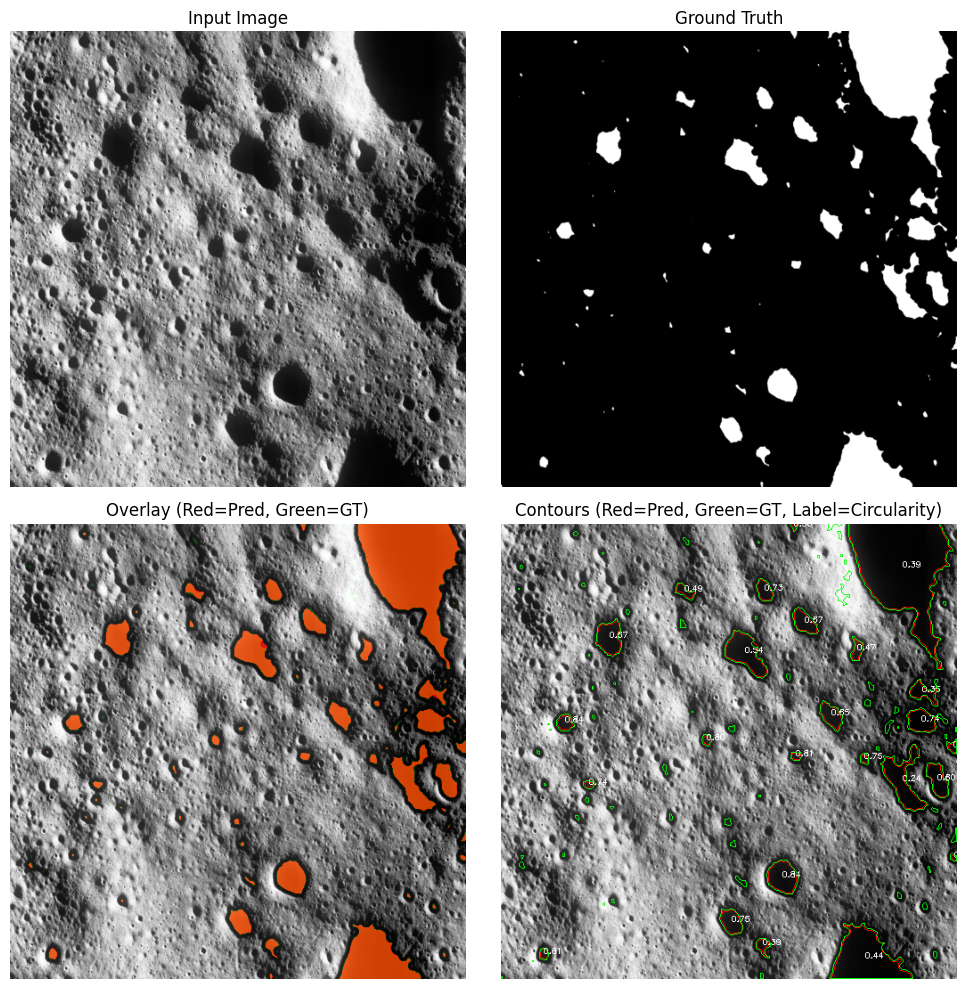

In [16]:
# Show sample predictions
show_all_visualizations(model, val_loader, num_samples=1)